##Texas Hospital Discharge - EDA

##Setup

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from scipy import stats
import yaml, time, sys, os, glob

import seaborn as sns
sns.set_style("darkgrid")

from IPython.display import display, Markdown
pd.set_option('display.max_columns', None)  

DATASET = "Texas_Inpatient_Discharge"
SPLIT_TRAINING = True
DEBUG = False
SEED = 42

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

In [17]:
if COLAB:
  from google.colab import drive
  if not os.path.isdir("/content/gdrive"):
    drive.mount("/content/gdrive")
    d = "/content/gdrive/MyDrive/datasets"
    if not os.path.isdir(d): os.makedirs(d)
  if not os.path.isdir(ROOT): os.makedirs(ROOT)

##Functions

In [18]:
def clean_cat (feature, mapping):
  if df[feature].dtype!="category":
    tmp = df[feature].map(mapping)
    assert tmp.isna().sum()==0, f"Found {tmp.isna().sum()} missing values"
    df[feature] = pd.Categorical(tmp)

##Dataset

In [19]:
df = pd.read_pickle(f"{ROOT}/data/df_train_sample_00_of_10.pkl")
print(df.shape)
df.head()

(99969, 195)


,RECORD_ID,DISCHARGE,THCIC_ID,PROVIDER_NAME,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,SPEC_UNIT_1,SPEC_UNIT_2,SPEC_UNIT_3,SPEC_UNIT_4,SPEC_UNIT_5,PAT_STATE,PAT_ZIP,PAT_COUNTRY,COUNTY,PUBLIC_HEALTH_REGION,PAT_STATUS,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,FIRST_PAYMENT_SRC,SECONDARY_PAYMENT_SRC,TYPE_OF_BILL,TOTAL_CHARGES,TOTAL_NON_COV_CHARGES,TOTAL_CHARGES_ACCOMM,TOTAL_NON_COV_CHARGES_ACCOMM,TOTAL_CHARGES_ANCIL,TOTAL_NON_COV_CHARGES_ANCIL,POA_PROVIDER_INDICATOR,ADMITTING_DIAGNOSIS,PRINC_DIAG_CODE,POA_PRINC_DIAG_CODE,OTH_DIAG_CODE_1,POA_OTH_DIAG_CODE_1,OTH_DIAG_CODE_2,POA_OTH_DIAG_CODE_2,OTH_DIAG_CODE_3,POA_OTH_DIAG_CODE_3,OTH_DIAG_CODE_4,POA_OTH_DIAG_CODE_4,OTH_DIAG_CODE_5,POA_OTH_DIAG_CODE_5,OTH_DIAG_CODE_6,POA_OTH_DIAG_CODE_6,OTH_DIAG_CODE_7,POA_OTH_DIAG_CODE_7,OTH_DIAG_CODE_8,POA_OTH_DIAG_CODE_8,OTH_DIAG_CODE_9,POA_OTH_DIAG_CODE_9,OTH_DIAG_CODE_10,POA_OTH_DIAG_CODE_10,OTH_DIAG_CODE_11,POA_OTH_DIAG_CODE_11,OTH_DIAG_CODE_12,POA_OTH_DIAG_CODE_12,OTH_DIAG_CODE_13,POA_OTH_DIAG_CODE_13,OTH_DIAG_CODE_14,POA_OTH_DIAG_CODE_14,OTH_DIAG_CODE_15,POA_OTH_DIAG_CODE_15,OTH_DIAG_CODE_16,POA_OTH_DIAG_CODE_16,OTH_DIAG_CODE_17,POA_OTH_DIAG_CODE_17,OTH_DIAG_CODE_18,POA_OTH_DIAG_CODE_18,OTH_DIAG_CODE_19,POA_OTH_DIAG_CODE_19,OTH_DIAG_CODE_20,POA_OTH_DIAG_CODE_20,OTH_DIAG_CODE_21,POA_OTH_DIAG_CODE_21,OTH_DIAG_CODE_22,POA_OTH_DIAG_CODE_22,OTH_DIAG_CODE_23,POA_OTH_DIAG_CODE_23,OTH_DIAG_CODE_24,POA_OTH_DIAG_CODE_24,E_CODE_1,POA_E_CODE_1,E_CODE_2,POA_E_CODE_2,E_CODE_3,POA_E_CODE_3,E_CODE_4,POA_E_CODE_4,E_CODE_5,POA_E_CODE_5,E_CODE_6,POA_E_CODE_6,E_CODE_7,POA_E_CODE_7,E_CODE_8,POA_E_CODE_8,E_CODE_9,POA_E_CODE_9,E_CODE_10,POA_E_CODE_10,PRINC_SURG_PROC_CODE,PRINC_SURG_PROC_DAY,PRINC_ICD9_CODE,OTH_SURG_PROC_CODE_1,OTH_SURG_PROC_DAY_1,OTH_ICD9_CODE_1,OTH_SURG_PROC_CODE_2,OTH_SURG_PROC_DAY_2,OTH_ICD9_CODE_2,OTH_SURG_PROC_CODE_3,OTH_SURG_PROC_DAY_3,OTH_ICD9_CODE_3,OTH_SURG_PROC_CODE_4,OTH_SURG_PROC_DAY_4,OTH_ICD9_CODE_4,OTH_SURG_PROC_CODE_5,OTH_SURG_PROC_DAY_5,OTH_ICD9_CODE_5,OTH_SURG_PROC_CODE_6,OTH_SURG_PROC_DAY_6,OTH_ICD9_CODE_6,OTH_SURG_PROC_CODE_7,OTH_SURG_PROC_DAY_7,OTH_ICD9_CODE_7,OTH_SURG_PROC_CODE_8,OTH_SURG_PROC_DAY_8,OTH_ICD9_CODE_8,OTH_SURG_PROC_CODE_9,OTH_SURG_PROC_DAY_9,OTH_ICD9_CODE_9,OTH_SURG_PROC_CODE_10,OTH_SURG_PROC_DAY_10,OTH_ICD9_CODE_10,OTH_SURG_PROC_CODE_11,OTH_SURG_PROC_DAY_11,OTH_ICD9_CODE_11,OTH_SURG_PROC_CODE_12,OTH_SURG_PROC_DAY_12,OTH_ICD9_CODE_12,OTH_SURG_PROC_CODE_13,OTH_SURG_PROC_DAY_13,OTH_ICD9_CODE_13,OTH_SURG_PROC_CODE_14,OTH_SURG_PROC_DAY_14,OTH_ICD9_CODE_14,OTH_SURG_PROC_CODE_15,OTH_SURG_PROC_DAY_15,OTH_ICD9_CODE_15,OTH_SURG_PROC_CODE_16,OTH_SURG_PROC_DAY_16,OTH_ICD9_CODE_16,OTH_SURG_PROC_CODE_17,OTH_SURG_PROC_DAY_17,OTH_ICD9_CODE_17,OTH_SURG_PROC_CODE_18,OTH_SURG_PROC_DAY_18,OTH_ICD9_CODE_18,OTH_SURG_PROC_CODE_19,OTH_SURG_PROC_DAY_19,OTH_ICD9_CODE_19,OTH_SURG_PROC_CODE_20,OTH_SURG_PROC_DAY_20,OTH_ICD9_CODE_20,OTH_SURG_PROC_CODE_21,OTH_SURG_PROC_DAY_21,OTH_ICD9_CODE_21,OTH_SURG_PROC_CODE_22,OTH_SURG_PROC_DAY_22,OTH_ICD9_CODE_22,OTH_SURG_PROC_CODE_23,OTH_SURG_PROC_DAY_23,OTH_ICD9_CODE_23,OTH_SURG_PROC_CODE_24,OTH_SURG_PROC_DAY_24,OTH_ICD9_CODE_24,MS_MDC,MS_DRG,MS_GROUPER_VERSION_NBR,MS_GROUPER_ERROR_CODE,APR_MDC,APR_DRG,RISK_MORTALITY,ILLNESS_SEVERITY,APR_GROUPER_VERSION_NBR,APR_GROUPER_ERROR_CODE,ATTENDING_PHYSICIAN_UNIF_ID,OPERATING_PHYSICIAN_UNIF_ID,ENCOUNTER_INDICATOR,CERT_STATUS,FILLER_SPACE,TARGET
884115,320136748870,2013Q3,838400,Memorial Hermann Rehab Hospital Katy,3,4,R,NaN,NaN,NaN,NaN,TX,77095,US,201,06,07,F,4,2,2,1,20,MA,MB,111,1671.00,0.00,1145.00,0.00,526.00,0.00,X,V5789,V5789,NaN,1919,Y,5119,Y,V8543,NaN,78459,Y,27801,Y,7812,Y,5180,Y,34590,Y,4019,Y,7993,Y,2724,Y,72887,Y,36250,Y,78093,Y,36901,Y,V5878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

##EDA

In [20]:
target = "TARGET"
cat_features = ["TYPE_OF_ADMISSION","SOURCE_OF_ADMISSION","PAT_STATE", "RACE"]
num_features = []

###Target

* Slightly imbalanced (especially for 'long')
  * Stratify when split on train-test or CV

In [21]:
df.TARGET.value_counts(dropna=False, normalize=True)

short     0.416429
medium    0.383079
long      0.200492
Name: TARGET, dtype: float64

###'RECORD_ID' - ignore

### 'DISCHARGE' - NKOA (NOT KNOWN ON ADMISSION)

### 'THCIC_ID' 
* Too many levels - need to merge rare before use

In [22]:
df.THCIC_ID.nunique()

566

### 'PROVIDER_NAME'

* Should be one-to-one with 'TCIC_ID' - so need only one
* Will decide (if) merging with faculty

In [23]:
df.PROVIDER_NAME.nunique()

561

### 'TYPE_OF_ADMISSION'

In [24]:
df.TYPE_OF_ADMISSION.value_counts(dropna=False)

1    43289
3    26046
2    16995
4    12738
5      476
9      421
`        4
Name: TYPE_OF_ADMISSION, dtype: int64

In [25]:
mapping = {
    "1" : "Emergency",
    "2": "Urgent",
    "3": "Elective",
    "4": "Newborn",
    "5": "Trauma Center Information",
    "9": "NA",
    "`": "NA",
    np.nan: "NA"
}

clean_cat("TYPE_OF_ADMISSION", mapping)

<Axes: >

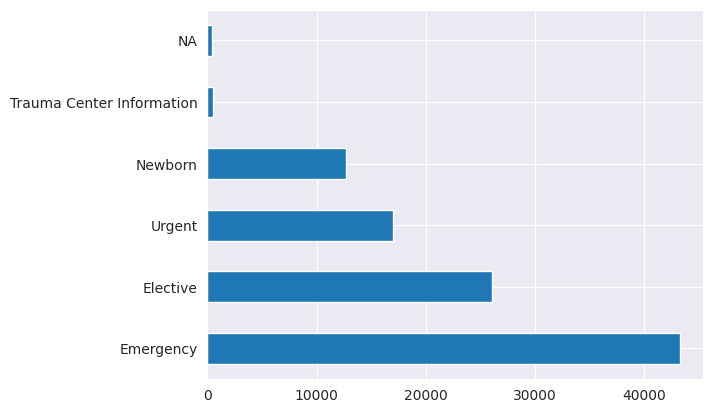

In [26]:
df.TYPE_OF_ADMISSION.value_counts().plot(kind="barh")

###'SOURCE_OF_ADMISSION'

* Need to come back and split 5 and 6 for newborns (see doc)

In [27]:
df.SOURCE_OF_ADMISSION.value_counts(dropna=False)

1      60209
2      17317
5      13211
4       6519
6        866
8        819
D        497
9        445
`         65
NaN       18
3          2
0          1
Name: SOURCE_OF_ADMISSION, dtype: int64

In [28]:
mapping = {
    "1" : "Non-healthcare Facility",
    "2": "Clinical referral",
    "4": "Transfer from a hospital",
    "5": "Transfer from nursing facility",
    "6": "Transfer from another facility",
    "8": "Court/Law",
    "9": "NA",
    "0": "Transfer from another facility",
    "D": "Internal",
    "3": "NA",
    "7": "NA",
    "`": "NA",
    np.nan: "NA",
}

clean_cat("SOURCE_OF_ADMISSION", mapping)

### 'PAT_STATE'

In [29]:
df.PAT_STATE.value_counts(dropna=False)

TX     97278
ZZ       818
NM       566
AR       463
OK       324
FC       264
LA       206
NaN       25
XX        19
`          6
Name: PAT_STATE, dtype: int64

In [30]:
mapping = {
    "AR" : "Arkansas",
    "LA": "Louisiana",
    "NM": "New Mexico",
    "OK": "Oklahoma",
    "TX": "Texas",
    "ZZ": "Other states",
    "FC": "Foreign",
    "XX": "Foreign",
    "`": "NA",
    np.nan: "NA",
}

clean_cat("PAT_STATE", mapping)

###'PAT_ZIP' - need to merge rare levels

In [31]:
df.PAT_ZIP.value_counts(dropna=False)

NaN      7215
88888     743
78521     401
`         360
78572     345
         ... 
75435       1
75086       1
79561       1
79608       1
76377       1
Name: PAT_ZIP, Length: 1789, dtype: int64

### 'PAT_COUNTRY'

* too imbalanced - might make binary features for US, NaN, MX, OTHER

In [32]:
df.PAT_COUNTRY.value_counts(dropna=False)

US     99085
NaN      634
MX       206
QA        12
SA         8
KW         5
CA         3
AE         3
HN         3
EG         2
PE         2
GT         1
EC         1
IN         1
DE         1
GB         1
NG         1
Name: PAT_COUNTRY, dtype: int64

### 'PAT_COUNTY'

* too many levels - need to merge

In [33]:
df.COUNTY.value_counts(dropna=False)

201    15670
113     9335
029     6833
439     6482
453     3523
       ...  
269        1
033        1
261        1
443        1
393        1
Name: COUNTY, Length: 254, dtype: int64

###'PUBLIC_HEALTH_REGION'

In [34]:
df.PUBLIC_HEALTH_REGION.value_counts(dropna=False)

03     25036
06     23180
07     10576
08     10118
11      8786
04      4649
05      3334
10      3261
01      3250
NaN     3246
02      2281
09      2252
Name: PUBLIC_HEALTH_REGION, dtype: int64

In [35]:
df.PUBLIC_HEALTH_REGION.fillna("NA", inplace=True)

###'SEX_CODE'

In [36]:
df.SEX_CODE.value_counts(dropna=False)

F      55828
M      37041
NaN     7086
U         14
Name: SEX_CODE, dtype: int64

In [37]:
mapping = {
    "F": "Female",
    "M": "Male",
    "U": "NA",
    np.nan: "NA",
}

clean_cat("SEX_CODE",mapping)

### 'RACE'

In [38]:
df.RACE.value_counts(dropna=False)

4      62448
5      21583
3      13270
2       1987
NaN      368
1        296
`         17
Name: RACE, dtype: int64

In [39]:
mapping = {
    "1": "American Indian",
    "2": "Asian",
    "3": "Black",
    "4": "White",
    "5": "Other",
    "`": "NA",
    np.nan: "NA",
}

clean_cat("RACE", mapping)

<Axes: >

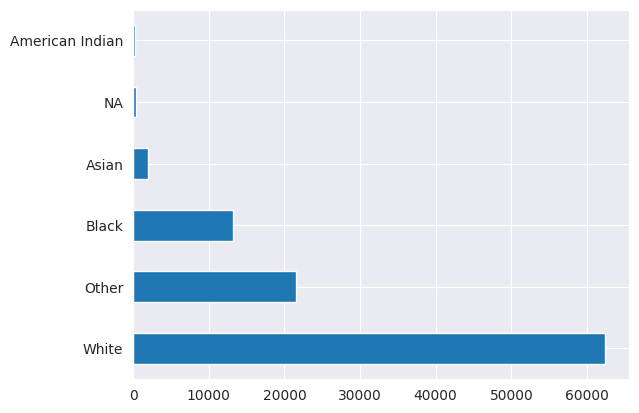

In [40]:
df.RACE.value_counts().plot(kind="barh")

###'ETHNICITY'

In [41]:
df.ETHNICITY.value_counts(dropna=False)

2      70118
1      28757
NaN      717
`        377
Name: ETHNICITY, dtype: int64

In [42]:
mapping = {
    "1": "Hispanic Origin",
    "2": "Not of Hispanic",
    "`": "NA",
    np.nan: "NA",
}

clean_cat("ETHNICITY", mapping)

In [43]:
pd.crosstab(df.ETHNICITY, df.RACE)

RACE,American Indian,Asian,Black,NA,Other,White
ETHNICITY,,,,,,
Hispanic Origin,73,59,412,39,16038,12136
NA,11,29,84,70,421,479
Not of Hispanic,212,1899,12774,276,5124,49833


In [45]:
df.to_pickle(f"{ROOT}/data/df_train_sample_00_of_1_clean.pkl")